# Example Kalman Filter for a Car

This notebook shows an example of the use of a kalman filter to estimate the position of a car that is being driven to a certain position.

In [1]:
import matplotlib.pyplot as plt

import random

## Basic car kinematics model

This shows the simulation of the system using the standard controller and car dynamics, assuming the controller has access to a perfect gps.

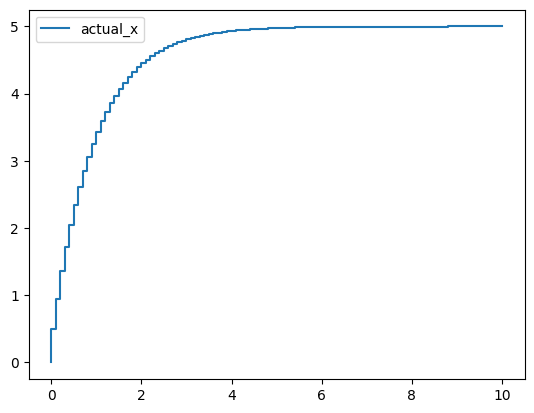

In [2]:
h = 0.1
tf = 10.0
N = int(tf/h)
p = 5.0

x_0 = 0.0

ctrl = lambda x: (p - x)   # Output of the controller is a velocity
x_next = lambda x: x + ctrl(x)*h   # Computes the next car position

xx = [x_0]
time = [0.0]

for i in range(N):
    xx.append(x_next(xx[i]))
    time.append(time[i]+h)

fig, (ax1) = plt.subplots(1, 1)
ax1.step(time, xx, label='actual_x')
ax1.legend()

plt.show()

## Noisy Kinematics Model

This shows the simulation of the system using the standard controller and car dynamics, but now the controller has an imperfect gps, and the car cannot be controlled perfectly.

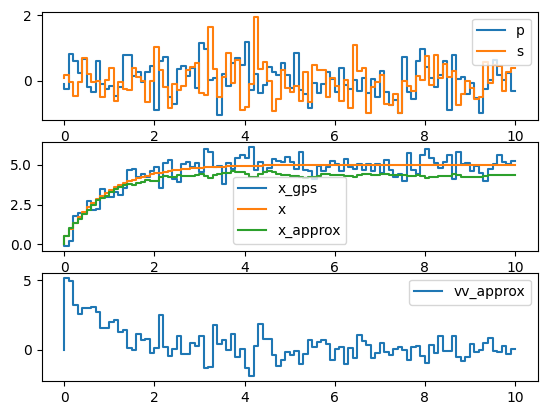

In [3]:
sigma_p = 0.5 # Position noise (measurement noise)
sigma_s = 0.5 # Controller speed noise (process noise)

pr = random.Random()
sr = random.Random()

np = [pr.gauss(0,sigma_p) for t in time]
ns = [sr.gauss(0,sigma_s) for t in time]

xx = [x_0]
xx_approx = [x_0]
xx_gps = [x_0]
vv_approx = [0]

for i in range(N):
    x = xx[i]
    
    # x_approx is the x calculated taking into account all noises.
    x_approx = xx_approx[i]
    x_gps = x + np[i]
    v_approx = (p - x_gps) + ns[i]  
    
    #xx stores the position free from noises.
    xx.append(x + (p - x)*h)
    
    xx_gps.append(x_gps)
    xx_approx.append(x_approx + v_approx*h)
    vv_approx.append(v_approx)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.step(time, np, label='p')
ax1.step(time, ns, label='s')
ax1.legend()

ax2.step(time, xx_gps, label='x_gps')
ax2.step(time, xx, label='x')
ax2.step(time, xx_approx, label='x_approx')
ax2.legend()

ax3.step(time, vv_approx, label='vv_approx')
ax3.legend()

plt.show()

Note how, in the steady state, the car drifts because it is constantly getting noisy signals about its position.

# Filtered Kinematics Model

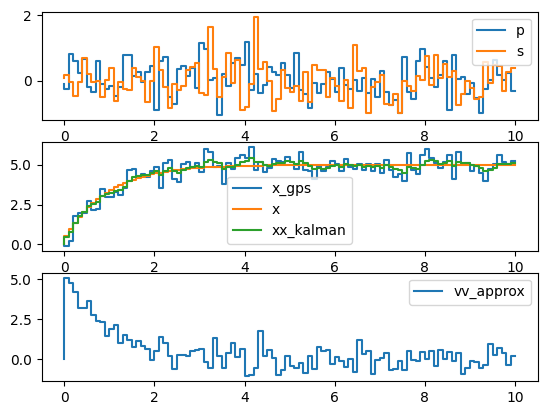

In [4]:
xx = [x_0]
xx_approx = [x_0]
xx_gps = [x_0]
xx_kalman = [x_0]
ns_kalman = [0.0]
vv_approx = [0]

ctrl = lambda x: (p-x)

for i in range(N):
    # Actual position
    x = xx[i]
    
    # Update position free from actuation noise
    xx.append(x + ctrl(x)*h)
    
    # Actual controller output (based on Kalman Filter)
    '''
    Note that we take the previous kalman estimation (at time i).
    Then we run the kalman filter to estimate i+1
    '''
    v_ctrl = ctrl(xx_kalman[i])
    # Add actuation noise
    v_approx = v_ctrl + ns[i]
    
    # Update position
    xx_approx.append(x + v_approx*h)
    vv_approx.append(v_approx)
    
    #### Update kalman filter ####
    
    # Gps value
    x_gps = x + np[i]
    xx_gps.append(x_gps)
    
    # Tentative Ctrl output
    v_tentative = v_ctrl
    
    # State estimate at i+1
    x_kalman_aux = xx_kalman[i] + v_tentative*h
    
    # Error variance estimate at i+1
    ns_kalman_aux = ns_kalman[i] + h*sigma_s
    
    # Measurement error estimate at i+1
    y = x_gps - x_kalman_aux
    
    # Compensation at i+1
    K = ns_kalman_aux / (sigma_p + ns_kalman_aux)
    
    # New state estimate at i+1
    x_kalman = x_kalman_aux + K*y
    
    xx_kalman.append(x_kalman)
    
    # New error estimate at i+1
    ns_kalman.append((1-K) * ns_kalman_aux)
    
    ################################
    
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.step(time, np, label='p')
ax1.step(time, ns, label='s')
ax1.legend()

ax2.step(time, xx_gps, label='x_gps')
ax2.step(time, xx, label='x')
ax2.step(time, xx_kalman, label='xx_kalman')
ax2.legend()

ax3.step(time, vv_approx, label='vv_approx')
ax3.legend()

plt.show()

Now behold how the kalman filter improves the drifting behavior around the steady state.